In [223]:
import pandas as pd

df = pd.read_csv('game_data.csv')

df = df.drop(columns=['scrape_id', 'main_story_polled', 'main_+_extras_polled', 'completionist_polled', 'all_playstyles_polled', 'developers', 'publishers', 'aliases', 'alias'])

df = df.dropna(subset=['genres'])
df = df.dropna(subset=['platforms'])

df['rating'] = pd.to_numeric(df['rating'], errors="coerce")
df = df.dropna(subset=['rating'])
df['rating'] = df['rating'] * 100
df['rating'] = df['rating'].astype(int)


df = df.dropna(subset=['na', 'eu', 'jp'], how='all')
df['eu'] = df['eu'].fillna(df['na'])
df['jp'] = df['jp'].fillna(df['na'])
df['eu'] = df['eu'].fillna(df['jp'])
df['jp'] = df['jp'].fillna(df['eu'])
df['na'] = df['na'].fillna(df['eu'])
df['eu'] = pd.to_datetime(df['eu'])
df['na'] = pd.to_datetime(df['na'])
df['jp'] = pd.to_datetime(df['jp'])

df = df.dropna(subset=['developer', 'publisher'], how='all')
df['developer'].fillna(df['publisher'], inplace=True)
df['publisher'].fillna(df['developer'], inplace=True)

for col in df.columns:
    if "main_story" in col or "main_+_extras" in col or "completionist" in col or "all_playstyles" in col:
        if "median" not in col:
            df = df.drop(columns=[col])
        else:
            df[col] = pd.to_timedelta(df[col], errors="coerce")

for col in df.columns:
    if "main_story" in col or "main_+_extras" in col or "completionist" in col or "all_playstyles" in col:
        df[col].fillna(df[col].mean(), inplace=True)

missing_values = df.isnull().sum()
print(missing_values)
df.count
# len(df.columns)


name                     0
rating                   0
beat_count               0
platforms                0
genres                   0
developer                0
publisher                0
na                       0
main_story_median        0
main_+_extras_median     0
completionist_median     0
all_playstyles_median    0
eu                       0
jp                       0
dtype: int64


<bound method DataFrame.count of                                              name  rating  beat_count  \
0                                   'Splosion Man      75         152   
1                     .hack//G.U. Vol. 1: Rebirth      76         225   
2                   .hack//G.U. Vol. 2: Reminisce      79         135   
3                  .hack//G.U. Vol. 3: Redemption      78         106   
4                                .hack//Infection      73         308   
...                                           ...     ...         ...   
10776          The Dark Pictures: The Devil in Me      66         233   
10777                Star Ocean: The Divine Force      76         103   
10778  Voice of Cards: The Isle Dragon Roars Demo      72          35   
10779                       Dogs Organized Neatly      76          43   
10780                                  Bloodshore      61          41   

                                               platforms  \
0                             

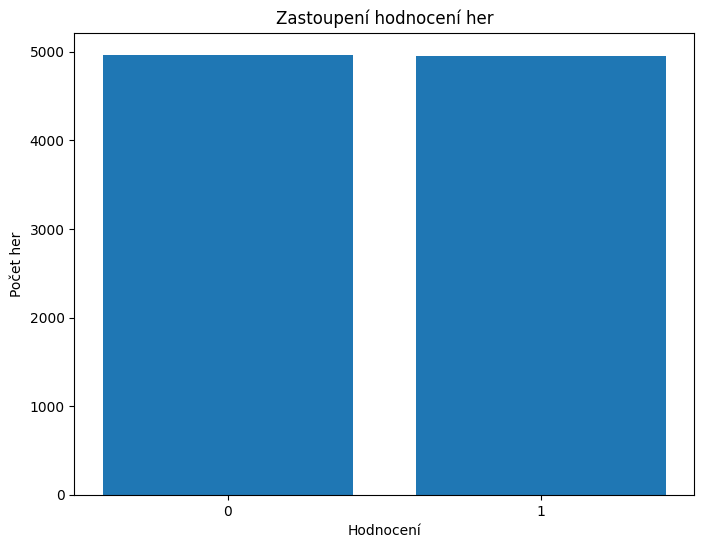

In [224]:
df['developer_count'] = df.groupby('developer')['name'].transform('count')
df['publisher_count'] = df.groupby('publisher')['name'].transform('count')

from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Vytvoříme 1D pole s počtem her vyvinutých každým vývojářem
X = np.array(df['developer_count']).reshape(-1, 1)

# Použijeme metodu lokte (elbow method) k určení optimálního počtu skupin
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
# plt.plot(range(1, 11), wcss)
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()
#
# # Podle výsledků grafu vybereme optimální počet skupin (v našem případě 3)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
df['developer_size'] = kmeans.fit_predict(X)

X = np.array(df['publisher_count']).reshape(-1, 1)

# Použijeme metodu lokte (elbow method) k určení optimálního počtu skupin
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
# plt.plot(range(1, 11), wcss)
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

# # Podle výsledků grafu vybereme optimální počet skupin (v našem případě 3)
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
df['publisher_size'] = kmeans.fit_predict(X)


# Definujte hranice pro rozdělení
threshold1 = 33.33  # První hranice
threshold2 = 66.66  # Druhá hranice


avg_game_treshold = 70
# Vytvořte funkci pro přiřazení do skupiny
def assign_group(value):
    if value <= avg_game_treshold:
        return 0
    else:
        return 1
    # else:
    #     return 2

# Aplikujte funkci na hodnocení hry
df['rating_group'] = df['rating'].apply(assign_group)

import matplotlib.pyplot as plt

# Vytvoření sloupce s hodnoceními
rating_counts = df['rating_group'].value_counts()

# Vytvoření grafu
plt.figure(figsize=(8, 6))
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Hodnocení')
plt.ylabel('Počet her')
plt.title('Zastoupení hodnocení her')
plt.xticks(rating_counts.index)
plt.show()

df = df.drop(columns=["developer","rating", "publisher", "name", "developer_count", "publisher_count", "all_playstyles_median"])
# df



In [225]:
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler

df["genres"] = df["genres"].apply(literal_eval)
df["platforms"] = df["platforms"].apply(literal_eval)

df['is_PC'] = df['platforms'].apply(lambda x: 1 if 'PC' in x else 0)
df['is_Console'] = df['platforms'].apply(lambda x: 1 if 'PC' not in x else 0)


# Rozbití listů na samostatné řádky
exploded_genres = df['genres'].explode()

# Výpočet četností jednotlivých žánrů
genre_counts = exploded_genres.value_counts()
rare_genres = genre_counts[genre_counts < 50].index

mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(df['genres']), columns=mlb.classes_, index=df.index)

# mlb = MultiLabelBinarizer()
# platforms_encoded = pd.DataFrame(mlb.fit_transform(df['platforms']), columns=mlb.classes_, index=df.index)

data_encoded = pd.concat([df , genres_encoded], axis=1)

data_encoded['na_year'] = data_encoded['na'].dt.year
data_encoded['na_month'] = data_encoded['na'].dt.month
data_encoded['na_day'] = data_encoded['na'].dt.day

# data_encoded['eu_year'] = data_encoded['eu'].dt.year
# data_encoded['eu_month'] = data_encoded['eu'].dt.month
# data_encoded['eu_day'] = data_encoded['eu'].dt.day
#
# data_encoded['jp_year'] = data_encoded['jp'].dt.year
# data_encoded['jp_month'] = data_encoded['jp'].dt.month
# data_encoded['jp_day'] = data_encoded['jp'].dt.day


data_encoded = data_encoded.drop(columns=["genres", "platforms", "na", "jp", "eu"])

for col in data_encoded.columns:
    if "main_story" in col or "main_+_extras" in col or "completionist" in col or "all_playstyles" in col:
        data_encoded[col] = data_encoded[col].dt.total_seconds() / 60

columns_to_check = ['main_story_median', 'main_+_extras_median', 'completionist_median']
threshold = 3  # Práh pro identifikaci odlehlých hodnot

# Vytvoření kopie DataFrame pro filtrování
filtered_data = data_encoded.copy()

# Iterace přes vybrané sloupce
for column in columns_to_check:
    # Výpočet z-score
    z_scores = np.abs((data_encoded[column] - data_encoded[column].mean()) / data_encoded[column].std())

    # Filtrace odlehlých hodnot
    filtered_data = filtered_data[z_scores < threshold]

data_encoded = filtered_data

scaler = MinMaxScaler()

data_encoded['main_story_normalized'] = scaler.fit_transform(data_encoded[['main_story_median']])
data_encoded['main_+_extras_normalized'] = scaler.fit_transform(data_encoded[['main_+_extras_median']])
data_encoded['completionist_normalized'] = scaler.fit_transform(data_encoded[['completionist_median']])
data_encoded['beat_count'] = scaler.fit_transform(data_encoded[['beat_count']])
# data_encoded[['main_story_median', 'main_+_extras_median', 'completionist_median']] = StandardScaler().fit_transform(data_encoded[['main_story_median', 'main_+_extras_median', 'completionist_median']])

# data_encoded[['beat_count']] = StandardScaler().fit_transform(data_encoded[['beat_count']])

data_encoded = data_encoded.drop(columns=[*columns_to_check, *rare_genres])

data_encoded

/var/folders/cx/lhmwf8r906d7f7785t7lwcdh0000gn/T/ipykernel_27559/271219847.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[z_scores < threshold]
/var/folders/cx/lhmwf8r906d7f7785t7lwcdh0000gn/T/ipykernel_27559/271219847.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[z_scores < threshold]


,beat_count,developer_size,publisher_size,rating_group,is_PC,is_Console,Action,Adventure,Arcade,Beat em Up,...,Tower Defense,Turn-Based,Virtual Reality,Visual Novel,na_year,na_month,na_day,main_story_normalized,main_+_extras_normalized,completionist_normalized
0,0.004609,0,0,1,0,1,1,0,0,0,...,0,0,0,0,2009,7,22,0.078904,0.041655,0.030806
1,0.007367,0,0,1,1,0,1,0,0,0,...,0,0,0,0,2006,10,24,0.186035,0.100070,0.069134
2,0.003967,0,0,1,1,0,1,0,0,0,...,0,0,0,0,2007,5,8,0.199901,0.125104,0.088798
3,0.002871,0,0,1,1,0,1,0,0,0,...,0,0,0,0,2008,3,25,0.207659,0.132684,0.093730
4,0.010502,0,0,1,0,1,1,0,0,0,...,0,0,0,0,2003,2,11,0.168868,0.083380,0.056150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10776,0.007669,0,0,0,1,0,0,1,0,0,...,0,0,0,0,2022,11,18,0.069000,0.035675,0.023534
10777,0.002758,0,1,1,1,0,1,0,0,0,...,0,0,0,0,2022,10,27,0.311654,0.191864,0.131059
10778,0.000189,2,1,1,1,0,0,0,0,0,...,0,0,0,0,2021,9,24,0.011225,0.006885,0.002778
10779,0.000491,0,0,1,1,0,0,0,0,0,...,0,0,0,0,2021,11,1,0.019478,0.008623,0.004651


In [226]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Najde duplicitní sloupce
duplicate_column_names = data_encoded.columns[data_encoded.columns.duplicated()]
# Odstraní duplicitní sloupce
data_encoded = data_encoded.drop(columns=duplicate_column_names)

class_distribution = data_encoded['rating_group'].value_counts()
print(class_distribution)

X = data_encoded.drop('rating_group', axis=1)
y = data_encoded['rating_group']




# Rozdělení dat na trénovací a testovací set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier(max_depth=30,n_estimators=120,random_state=1)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print("Accuracy: ",accuracy_score(y_test, y_pred))


f_score = f1_score(y_test, y_pred, average='macro')

print("F-score: ", f_score)

# Matice záměn
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)

# Pokud máte binární klasifikaci
if len(set(y_test)) == 2:
    # ROC AUC skóre
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC AUC Score: ", roc_auc)
else:
    # Pokud máte více tříd, potřebujete binarizovat cíle pro ROC AUC
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_lb = lb.transform(y_test)
    y_pred_lb = lb.transform(y_pred)
    roc_auc = roc_auc_score(y_test_lb, y_pred_lb, average='macro')
    print("ROC AUC Score: ", roc_auc)

# Log Loss
# Prvně musíme získat pravděpodobnosti předpovědí, ne třídy
y_pred_prob = model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_prob)
print("Log Loss: ", logloss)

rating_group
0    4936
1    4905
Name: count, dtype: int64
Accuracy:  0.7430167597765364
F-score:  0.7418741903725581
Confusion Matrix: 
 [[797 231]
 [275 666]]
ROC AUC Score:  0.7415247666816907
Log Loss:  0.5272169160800346


In [227]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Definujeme mřížku hyperparametrů, které chceme prozkoumat
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [25, 30, 35],
    'learning_rate': [0.01, 0.1, 0.2]
}

xgb_model = XGBClassifier(eval_metric='mlogloss')

# Definujeme GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=3, scoring='accuracy')

# Natrénování GridSearchCV
grid_search_xgb.fit(X_train, y_train)

print("Nejlepší hyperparametry pro XGBClassifier: ", grid_search_xgb.best_params_)

# Získání nejlepšího modelu
best_xgb = grid_search_xgb.best_estimator_

# Predikce
y_pred_xgb = best_xgb.predict(X_test)

# Zobrazíme přesnost modelu
print("XGBClassifier Accuracy: ", accuracy_score(y_test, y_pred_xgb))

# Vypočteme F1 skóre
f_score_xgb = f1_score(y_test, y_pred_xgb, average='macro')
print("XGBClassifier F-score: ", f_score_xgb)

cm = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix: \n", cm)

# Pokud máte binární klasifikaci
if len(set(y_test)) == 2:
    # ROC AUC skóre
    roc_auc = roc_auc_score(y_test, y_pred_xgb)
    print("ROC AUC Score: ", roc_auc)
else:
    # Pokud máte více tříd, potřebujete binarizovat cíle pro ROC AUC
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_lb = lb.transform(y_test)
    y_pred_lb = lb.transform(y_pred_xgb)
    roc_auc = roc_auc_score(y_test_lb, y_pred_lb, average='macro')
    print("ROC AUC Score: ", roc_auc)

# Log Loss
# Prvně musíme získat pravděpodobnosti předpovědí, ne třídy
y_pred_prob = model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_prob)
print("Log Loss: ", logloss)


Nejlepší hyperparametry pro XGBClassifier:  {'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 100}
XGBClassifier Accuracy:  0.7343829355002539
XGBClassifier F-score:  0.7336682221418176
Confusion Matrix: 
 [[774 254]
 [269 672]]
ROC AUC Score:  0.7335260940220065
Log Loss:  0.5272169160800346


In [228]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Definujeme mřížku hyperparametrů, které chceme prozkoumat
param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [1, 0.1, 0.01]
}

svc_model = make_pipeline(StandardScaler(), SVC())

# Definujeme GridSearchCV
grid_search_svc = GridSearchCV(svc_model, param_grid_svc, cv=3, scoring='accuracy')

# Natrénování GridSearchCV
grid_search_svc.fit(X_train, y_train)

print("Nejlepší hyperparametry pro SVC: ", grid_search_svc.best_params_)

# Získání nejlepšího modelu
best_svc = grid_search_svc.best_estimator_

# Predikce
y_pred_svc = best_svc.predict(X_test)

# Zobrazíme přesnost modelu
print("SVC Accuracy: ", accuracy_score(y_test, y_pred_svc))

# Vypočteme F1 skóre
f_score_svc = f1_score(y_test, y_pred_svc, average='macro')
print("SVC F-score: ", f_score_svc)

cm = confusion_matrix(y_test, y_pred_svc)
print("Confusion Matrix: \n", cm)

# Pokud máte binární klasifikaci
if len(set(y_test)) == 2:
    # ROC AUC skóre
    roc_auc = roc_auc_score(y_test, y_pred_svc)
    print("ROC AUC Score: ", roc_auc)
else:
    # Pokud máte více tříd, potřebujete binarizovat cíle pro ROC AUC
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_lb = lb.transform(y_test)
    y_pred_lb = lb.transform(y_pred_svc)
    roc_auc = roc_auc_score(y_test_lb, y_pred_lb, average='macro')
    print("ROC AUC Score: ", roc_auc)

# Log Loss
# Prvně musíme získat pravděpodobnosti předpovědí, ne třídy
y_pred_prob = model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_prob)
print("Log Loss: ", logloss)


Nejlepší hyperparametry pro SVC:  {'svc__C': 10, 'svc__gamma': 0.01}
SVC Accuracy:  0.6988318943626206
SVC F-score:  0.6939771566027346
Confusion Matrix: 
 [[812 216]
 [377 564]]
ROC AUC Score:  0.6946228244644119
Log Loss:  0.5272169160800346
